In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(42)

# Helper functions

In [2]:
def learning_success_rate(u_func, u_target, num_angles, num_samples, key, **kwargs):
    
    initial_angles = random.uniform(key, shape=(num_samples, num_angles), minval=0, maxval=2*jnp.pi)
    cost_func = lambda angs: disc2(u_func(angs), u_target)
    angles_and_loss_histories = gradient_descent_learn(cost_func, 
                                                       num_angles,
                                                       initial_angles=initial_angles,
                                                       **kwargs)
    
    best_losses = [min(hist) for (_, hist) in angles_and_loss_histories]
    sucess_history = [loss<kwargs['target_disc'] for loss in best_losses]
    return angles_and_loss_histories, sucess_history

def chart_learning_success_rate(num_qubits, key, num_samples=20, min_depth=0, max_depth=0, **kwargs):

    success_rates = []
    for d in range(min_depth, max_depth+1):
        a = Ansatz(num_qubits, 'cz', fill_layers(sequ_layer(num_qubits), d))
        key, subkey = random.split(key)
        target_angles = random.uniform(subkey, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
        u_target = a.unitary(target_angles)
        
        key, subkey = random.split(key)
        _, success_history = learning_success_rate(a.unitary, u_target, a.num_angles, num_samples, subkey, **kwargs)
        success_rate = jnp.array(success_history).sum()/len(success_history)
        success_rates.append(success_rate)
        
    return success_rates

# 2-qubit

In [3]:
max_depth = theoretical_lower_bound(2)+3
num_samples = 20

In [4]:
%%time
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(2, 
                                            subkey, 
                                            num_samples=num_samples, 
                                            max_depth=max_depth,
                                            num_iterations=5000,
                                            target_disc=1e-3)

with open('success_rates_2.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 43.7 s, sys: 1.69 s, total: 45.4 s
Wall time: 40.4 s


Text(0.5, 1.0, 'number of samples: 20')

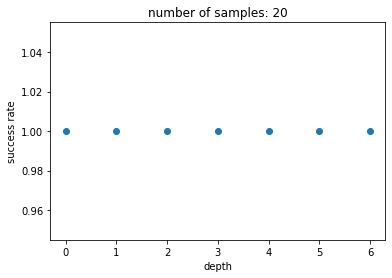

In [6]:
with open('success_rates_2.pickle', 'rb') as f:
     success_rates = pickle.load(f)

plt.scatter(range(max_depth+1), success_rates)
plt.xlabel('depth')
plt.ylabel('success rate')
plt.title('number of samples: {}'.format(num_samples))

# 3-qubit

## Full sweep

In [12]:
min_depth=0
max_depth = theoretical_lower_bound(3)+2

In [13]:
%%time
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(3, subkey, 
                                            num_samples=20, 
                                            min_depth=min_depth,
                                            max_depth=max_depth,
                                            num_iterations=5000,
                                            target_disc=1e-3)

with open('success_rates_3.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 13min 34s, sys: 43.6 s, total: 14min 18s
Wall time: 11min 39s


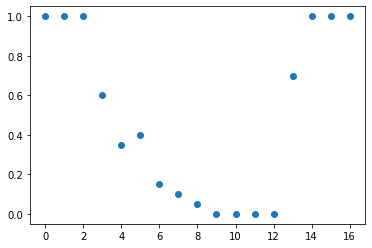

In [15]:
with open('success_rates_3.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(min_depth, max_depth+1), success_rates)

## Zoom in on middle range

As the plot above shows, GD appears to get stuck in local minimums a lot in the depth range 7-12. Let us zoom in on this region.

In [16]:
%%time
min_depth = 9
max_depth = 13
num_samples = 100

key, subkey = random.split(key)
success_rates = chart_learning_success_rate(3, subkey, 
                                            num_samples=num_samples, 
                                            min_depth=min_depth,
                                            max_depth=max_depth,
                                            num_iterations=5000,
                                            target_disc=1e-3)

with open('success_rates_3_zoom.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 29min 10s, sys: 1min 43s, total: 30min 54s
Wall time: 23min 58s


[array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0.01, dtype=float32), array(0.59, dtype=float32)]


Text(0.5, 1.0, 'num samples = 100')

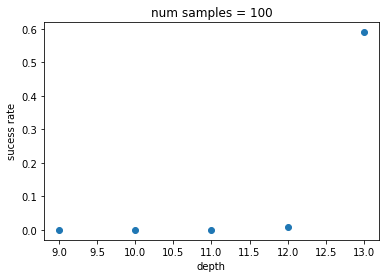

In [72]:
with open('success_rates_3_zoom.pickle', 'rb') as f:
     success_rates = pickle.load(f)

print(success_rates)
plt.scatter(range(min_depth, max_depth+1), success_rates)
plt.xlabel('depth')
plt.ylabel('sucess rate')
plt.title('num samples = {}'.format(num_samples))

## Distribution of local minimums

Further experiments do not confirm conjecture that most of the local minumums are the same.

CPU times: user 41.9 s, sys: 2.31 s, total: 44.2 s
Wall time: 36.8 s


(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  5.]),
 array([9.6201897e-05, 1.8061135e-02, 3.6026068e-02, 5.3991001e-02,
        7.1955934e-02, 8.9920871e-02, 1.0788580e-01, 1.2585074e-01,
        1.4381567e-01, 1.6178060e-01, 1.7974554e-01, 1.9771047e-01,
        2.1567540e-01, 2.3364033e-01, 2.5160527e-01, 2.6957020e-01,
        2.8753513e-01, 3.0550006e-01, 3.2346499e-01, 3.4142995e-01,
        3.5939488e-01, 3.7735981e-01, 3.9532474e-01, 4.1328967e-01,
        4.3125460e-01, 4.4921952e-01, 4.6718445e-01, 4.8514941e-01,
        5.0311434e-01, 5.2107924e-01, 5.3904420e-01], dtype=float32),
 <BarContainer object of 30 artists>)

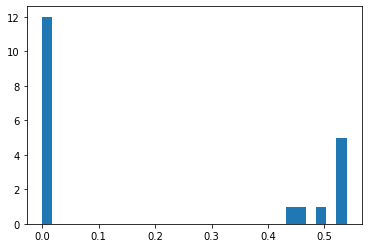

In [70]:
%%time
num_qubits = 3
depth = 7


anz = Ansatz(3, 'cz', placements=fill_layers(chain_layer(3), 4))
key, subkey = random.split(key)
target_angles = random.uniform(subkey, shape=(anz.num_angles,), minval=0, maxval=2*jnp.pi)
u_target = anz.unitary(target_angles)

key, subkey = random.split(key)
angles_and_loss_histories, sucess_history = learning_success_rate(anz.unitary, 
                                                                  u_target,
                                                                  anz.num_angles,
                                                                  20,
                                                                  key,
                                                                  target_disc=1e-4)

best_losses = [h[-1] for _, h in angles_and_loss_histories]
plt.hist(jnp.array(best_losses), bins=30)

## Lowest point

OK, seems that another zoom-in is in order. Let's just do depth=9.

In [73]:
%%time
key, subkey = random.split(key)
chart_learning_success_rate(3, 
                            subkey, 
                            num_samples=1000, 
                            min_depth=9,
                            max_depth=9,
                            num_iterations=2000,
                            target_disc=1e-3)

CPU times: user 24min 26s, sys: 1min 31s, total: 25min 57s
Wall time: 20min 10s


[DeviceArray(0.011, dtype=float32)]

## Toffoli 3 

Let us also check directly the success rate for the toffoli gate.

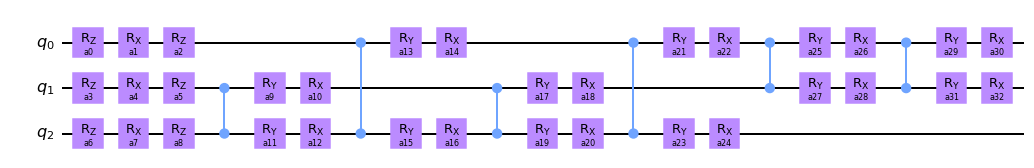

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cz', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

In [37]:
%%time

num_samples=20
key, subkey = random.split(key)
angles_and_loss_histories, success_history_toff3 = learning_success_rate(anz_toff3.unitary, 
                                      u_toff3, 
                                      anz_toff3.num_angles, 
                                      num_samples, 
                                      subkey,
                                      target_disc=1e-4)

CPU times: user 1min 3s, sys: 4.22 s, total: 1min 7s
Wall time: 55.4 s


Success rate is

In [40]:
jnp.array(success_history_toff3).sum()/len(success_history_toff3)

DeviceArray(0.2, dtype=float32)

An interesting fact is that the almost all failed attempts are stuck in the same local minumum value.

In [42]:
[h[-1] for _, h in angles_and_loss_histories if h[-1]>1e-4]

[DeviceArray(0.146447, dtype=float32),
 DeviceArray(0.14644676, dtype=float32),
 DeviceArray(0.14644647, dtype=float32),
 DeviceArray(0.14644635, dtype=float32),
 DeviceArray(0.146447, dtype=float32),
 DeviceArray(0.14644724, dtype=float32),
 DeviceArray(0.14644724, dtype=float32),
 DeviceArray(0.14644676, dtype=float32),
 DeviceArray(0.57322323, dtype=float32),
 DeviceArray(0.14644676, dtype=float32),
 DeviceArray(0.14644724, dtype=float32),
 DeviceArray(0.14644653, dtype=float32),
 DeviceArray(0.14644653, dtype=float32),
 DeviceArray(0.14644653, dtype=float32),
 DeviceArray(0.14644688, dtype=float32),
 DeviceArray(0.14644676, dtype=float32)]

It does not seem possible to find a value below the dominating local minimum by naive sampling. In fact, even getting fidelity near 80% is very hard.

In [46]:
def find_below_treshold(cost_func, num_angles, num_attempts=100, threshhold=0.1):
    for k in range(num_attempts):
        angles = random.uniform(random.PRNGKey(k), 
                                shape=(num_angles, ), 
                                minval=0, 
                                maxval=2*jnp.pi)
        cost = cost_func(angles)
        if cost<threshhold:
            return angles
        
    print('not found')

In [48]:
%%time
overlap = jit(lambda angs: disc2(anz_toff3.unitary(angs), u_toff3))
find_below_treshold(overlap,
                    anz_toff3.num_angles, 
                    num_attempts=50000, 
                    threshhold=0.8)

CPU times: user 1min 21s, sys: 6.15 s, total: 1min 28s
Wall time: 1min 13s


DeviceArray([5.2530184 , 5.513037  , 2.29013   , 2.8192403 , 0.3081886 ,
             4.0115075 , 5.370657  , 0.75173223, 5.8935275 , 0.419179  ,
             3.9311795 , 5.0833397 , 5.8756514 , 3.1994467 , 0.5335347 ,
             3.4507296 , 1.8419687 , 3.2537718 , 2.0118923 , 4.709503  ,
             2.7546117 , 5.4779077 , 0.7300296 , 5.458556  , 2.2637603 ,
             3.4483762 , 3.5452993 , 3.505454  , 6.228811  , 4.3201027 ,
             0.34771556, 4.4520235 , 4.7252684 ], dtype=float32)

## Loss history in local minimum

CPU times: user 13.1 s, sys: 64.4 ms, total: 13.2 s
Wall time: 12.7 s


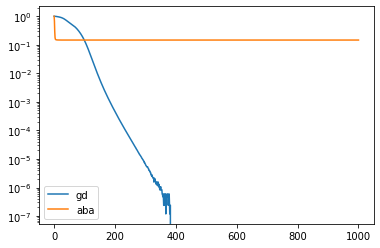

In [35]:
%%time
initial_angles = random.uniform(random.PRNGKey(20), (anz_toff3.num_angles,), minval=0, maxval=2*jnp.pi)
angles_hisotory, loss_history = anz_toff3.learn(u_toff3, initial_angles=initial_angles, num_iterations=1000)
_, loss_history_aba = anz_toff3.learn(u_toff3, initial_angles=initial_angles, num_iterations=1000, method='aba')
plt.plot(loss_history, label='gd')
plt.plot(loss_history_aba, label='aba')
plt.legend()
plt.yscale('log')

In [ ]:
anz.

In [36]:
loss_history_aba[-1]

DeviceArray(0.146447, dtype=float32)

In [34]:
loss_history[-1]

DeviceArray(0.14644653, dtype=float32)

CPU times: user 5.53 s, sys: 35.4 ms, total: 5.56 s
Wall time: 5.43 s


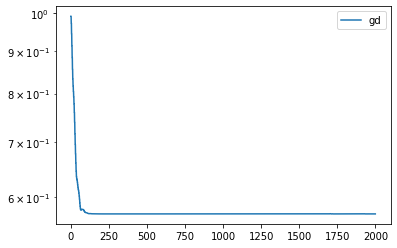

In [11]:
%%time
initial_angles = random.uniform(random.PRNGKey(8), (anz_toff3.num_angles,), minval=0, maxval=2*jnp.pi)
angles_history, loss_history = anz_toff3.learn(u_toff3, initial_params=initial_angles, num_iterations=1000)
#  _, loss_history_aba = anz_toff3.learn(u_toff3, initial_angles=initial_angles, num_iterations=1000, method='aba')
plt.plot(loss_history, label='gd')
# plt.plot(loss_history_aba, label='aba')
plt.legend()
plt.yscale('log')

In [12]:
def toff3_cost(angles):
    return disc2(anz_toff3.unitary(angles), u_toff3)

jax.grad(toff3_cost)(angles_history[-1])

DeviceArray([ 3.6358833e-06,  1.6221293e-08,  3.5911798e-06,
             -1.0112375e-03, -2.0089806e-07, -1.0112301e-03,
              7.0780516e-08, -7.1269460e-07, -2.9802322e-08,
             -7.4505806e-07, -8.0429018e-04, -7.4505806e-08,
              6.7637302e-08, -3.4272671e-07,  3.6358833e-06,
              1.4901161e-08, -7.1144314e-08,  0.0000000e+00,
              1.6689301e-06, -1.1754694e-04,  5.8362275e-08,
             -1.3411045e-07, -5.9604645e-08,  1.7460115e-07,
             -7.1525574e-07, -2.2351742e-07, -1.5273690e-07,
             -6.7055225e-07,  7.8129233e-08,  3.3080578e-06,
             -1.4901161e-08, -5.7000790e-08, -4.0114310e-07],            dtype=float32)

In [14]:
toffeigs = jnp.linalg.eigvals(jax.hessian(toff3_cost)(angles_history[-1]))

In [15]:
toffeigs

DeviceArray([ 8.5051483e-01+0.j,  6.7552692e-01+0.j,  6.0802937e-01+0.j,
              4.9082175e-01+0.j,  5.3367782e-01+0.j,  4.2789227e-01+0.j,
              4.3555638e-01+0.j,  4.0900460e-01+0.j,  2.5589207e-01+0.j,
              2.5172666e-01+0.j,  2.3867965e-01+0.j,  2.2540231e-01+0.j,
              1.9473420e-01+0.j,  1.9404107e-01+0.j,  1.4852816e-01+0.j,
              1.2634420e-01+0.j,  1.2135269e-01+0.j,  7.7274919e-02+0.j,
              8.1190050e-02+0.j,  3.7423670e-02+0.j,  2.1338667e-01+0.j,
              2.1338712e-01+0.j,  2.1339077e-01+0.j,  1.2996628e-02+0.j,
              3.7703526e-03+0.j,  1.0596151e-03+0.j,  1.6999403e-04+0.j,
             -1.8031585e-06+0.j, -9.5436963e-07+0.j, -2.0153816e-07+0.j,
             -6.1641270e-09+0.j, -3.2521601e-08+0.j, -4.3252093e-08+0.j],            dtype=complex64)

## Learning in the complex plane

Preliminary results are nor enterily clear but still interesting.
1. The complex GD looks like it would benefit greatly from improved convergence --> implement natural gradient!
1. To compare the two approaches it is necessary to collect statistics and not just look at single runs.

In [100]:
def complex_toffoli_cost(c_angles, reg):
    n_angles = len(c_angles)//2
    re_angles = c_angles[:n_angles]
    im_angles = c_angles[n_angles:]
    angles = re_angles + 1j*im_angles
    disc_cost = jnp.abs(disc2(anz_toff3.unitary(angles), u_toff3))
    reg_cost = reg*(jnp.imag(angles)**2).sum()
    return disc_cost + reg_cost

In [125]:
c_angles_re = random.uniform(random.PRNGKey(0), shape=(anz_toff3.num_angles,), minval=0, maxval=2*jnp.pi)
c_angles_im = random.normal(random.PRNGKey(0), shape=(anz_toff3.num_angles,))

c_angles = jnp.concatenate([c_angles_re, 0*c_angles_im])


angles_history, loss_history = gradient_descent_learn(lambda angs: disc2(anz_toff3.unitary(angs), u_toff3), 
                                                      anz_toff3.num_angles, 
                                                      initial_angles=c_angles_re,
                                                      target_disc=1e-4,
                                                      learning_rate=0.001,
                                                      num_iterations=200000)

In [123]:
%%time
angles_history_c, loss_history_c = gradient_descent_learn(lambda angs: complex_toffoli_cost(angs, 0.01), 
                                                      2*anz_toff3.num_angles, 
                                                      initial_angles=c_angles,
                                                      target_disc=1e-4,
                                                      learning_rate=0.001,
                                                      num_iterations=200000)

CPU times: user 1min 58s, sys: 7.54 s, total: 2min 6s
Wall time: 1min 41s


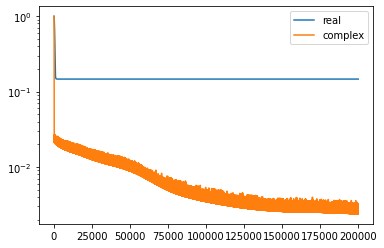

In [128]:
plt.plot(loss_history, label='real')
plt.plot(loss_history_c, label='complex')
plt.legend()
plt.yscale('log')

In [129]:
disc2(anz_toff3.unitary(angles_history[-1]), u_toff3)

DeviceArray(0.14644653, dtype=float32)

In [130]:
disc2(anz_toff3.unitary(angles_history_c[-1][:33]), u_toff3)

DeviceArray(0.16411108, dtype=float32)

# 4-qubit

## Full sweep

In [78]:
min_depth=0
max_depth = theoretical_lower_bound(4)+2

In [79]:
%%time
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(4, subkey, 
                                            num_samples=20, 
                                            min_depth=min_depth,
                                            max_depth=max_depth,
                                            num_iterations=5000,
                                            target_disc=1e-3)

with open('success_rates_4.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 1h 57min 6s, sys: 3min 33s, total: 2h 40s
Wall time: 1h 28min 45s


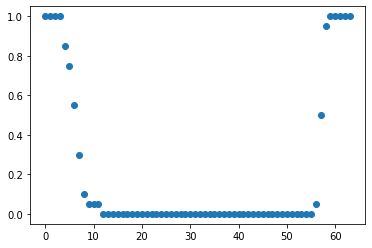

In [80]:
with open('success_rates_4.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(min_depth, max_depth+1), success_rates)

In [41]:
%%time
max_depth = theoretical_lower_boundical_lower_bound(4)+2

key, subkey = random.split(key)
success_rates = chart_learning_success_rate(4, subkey, n_samples=20, 
                                            max_depth=max_depth,
                                            target_disc=1e-3)
with open('success_rates_4.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 1h 52min 44s, sys: 3min 32s, total: 1h 56min 17s
Wall time: 1h 26min 25s


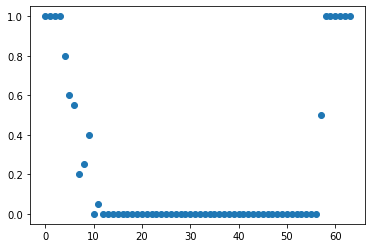

In [43]:
max_depth = theoretical_lower_bound(4)+2
with open('success_rates_4.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(max_depth+1), success_rates)

## Middle point

In [77]:
num_samples=200
key, subkey = random.split(key)

print('30-gate unitary sucess rate')
chart_learning_success_rate(4, 
                            subkey, 
                            num_samples=num_samples, 
                            min_depth=30,
                            max_depth=31,
                            target_disc=1e-3)

30-gate unitary sucess rate


[DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32)]

## Toffoli 4

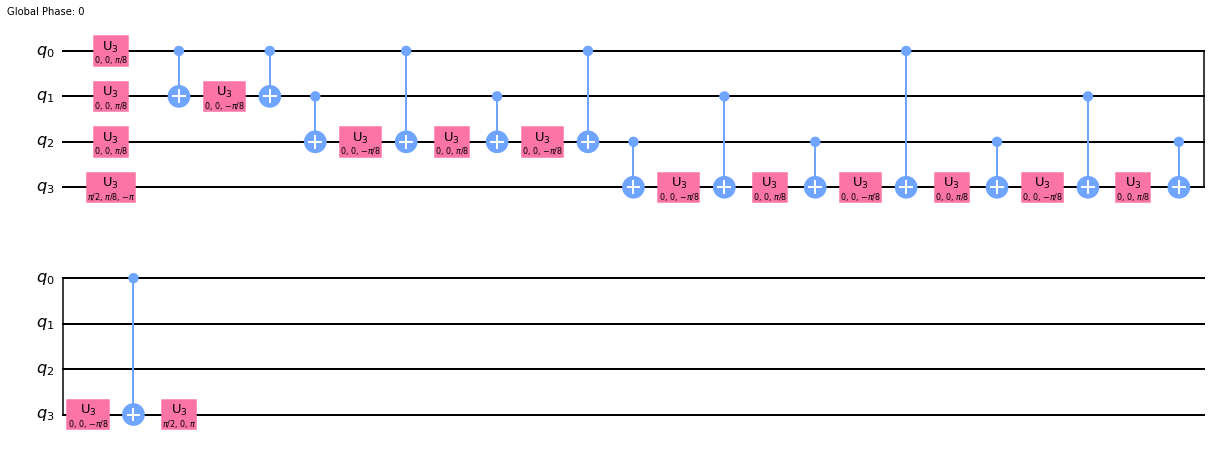

In [3]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

qc.draw(output='mpl')
transpile(qc, basis_gates=['u3', 'cx'], optimization_level=3).draw(output='mpl')

In [10]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

qc.draw(output='mpl')
qc_
u_toff4_trans = Operator(transpile(qc, basis_gates=['u3', 'cx'], coupling_map=[[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]], optimization_level=3)).data

In [12]:


jnp.allclose(Operator(u_toff4_trans).data,Operator(u_toff4).data)

DeviceArray(False, dtype=bool)

In [45]:
placements_toff4 = [[0, 1], [0, 1], [1, 2], [0, 2], [1, 2], [0, 2], [2, 3], [1, 3], [2, 3], [0, 3], [2, 3], [1, 3], [2, 3], [0, 3]]
anz_toff4 = Ansatz(4, 'cz', placements={'free': placements_toff4})

In [49]:
%%time

num_samples=100
key, subkey = random.split(key)
_, success_history_toff4 = learning_success_rate(
                                      anz_toff4.unitary, 
                                      u_toff4, 
                                      anz_toff4.num_angles, 
                                      num_samples, 
                                      subkey,
                                      target_disc=1e-4)

print('Toffoli4 sucess rate')
jnp.array(success_history_toff4).sum()/num_samples

Toffoli4 sucess rate
CPU times: user 8min 43s, sys: 22.8 s, total: 9min 6s
Wall time: 6min 59s


DeviceArray(0.01, dtype=float32)